# Chief-deputy Rendezvous and Docking on an Elliptical Orbit
© 2023 Tomohiro Sasaki, All Rights Reserved.

## Import libraries

In [1]:
using Plots; gr()
using LinearAlgebra
using Revise
using CDDP # import CDDP module

using DifferentialEquations
using DataInterpolations
using BenchmarkTools
using Printf

## Define Simulation Setup

In [2]:
# tf = 60 * 60 * 24. # final time 
tf = 150000. # final time
tN = 3000 # number of time steps
dt = tf/tN # time step
hN = 1000; # horizon length
Ts = 1.0; # sampling time
Tsc = 1.0; # sampling time for control



## Define Dynamics Model

In [3]:
includet("../src/models/chiefdeputy.jl")
model = ChiefDeputy()

# initial state
x_init = model.x_init
@printf("Initial State: %s \n", x_init)

# final state
x_final = model.x_final
@printf("Final State: %s \n", x_final)

# model dimensions
nx, nu = model.dims.nx, model.dims.nu
@printf("nx: %i, nu: %i", nx, nu)

Initial State: [0.45454545454545453, 0.0, 0.9090909090909091, 0.0, -0.6974518910635283, 0.0] 
Final State: [0.22727272727272727, 0.0, 0.45454545454545453, 0.0, -0.34872594553176417, 0.0] 


nx: 6, nu: 3

## Propagate Chief Spacecraft Orbit

In [4]:
Œ, _ = initialize_trajectory(model, tf, tN, model.œ_init, model.fc!)
model.params.Œ = Œ;

In [5]:
X0, U0 = initialize_trajectory(model, tf, hN, x_init, model.f!, U_md=Œ);


┌ Error: Failed to revise /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl
│   exception = (LoadError("/Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl", 139, "missing condition in \"if\" at /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl:138"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000176a398cf])
└ @ Revise /Users/astomodynamics/.julia/packages/Revise/7HQ7u/src/packagedef.jl:725
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.


┌ Error: Failed to revise /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl
│   exception = (LoadError("/Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl", 149, "\"if\" at /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/src/utils/utils_trajectory.jl:131 expected \"end\", got \"else\""), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000176a398cf])
└ @ Revise /Users/astomodynamics/.julia/packages/Revise/7HQ7u/src/packagedef.jl:725


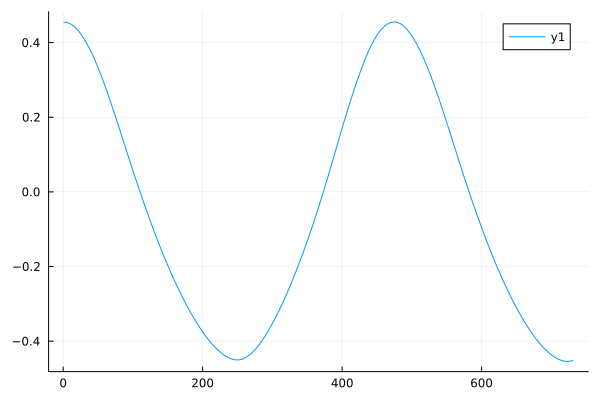

In [6]:
plot(X0[1,:])

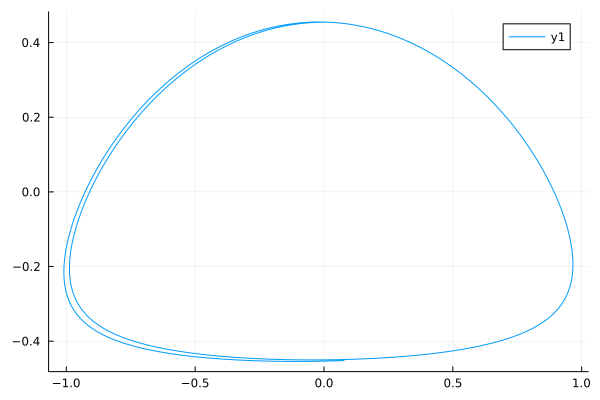

In [7]:
plot(X0[2,:], X0[1,:])

## Define Cost Functions for Trajecotry Optimization

In [8]:
# function ell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
#     Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
#     R = Diagonal(1e+2 * [1; 1; 1])
#     if x_ref == nothing
#         return x'*Q*x + u'*R*u
#     else
#         return (x-x_ref)'*Q*(x-x_ref) + u'*R*u
#     end
# end

# function phi_cost(x::Vector; x_ref::Vector=nothing)
#     Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]; [0.]])
#     if x_ref == nothing
#         return x'*Qf*x
#     else
#         return (x-x_ref)'*Qf*(x-x_ref)
#     end
# end

# function ∇ₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
#     Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
#     R = Diagonal(1e+2 * [1; 1; 1])
#     if x_ref == nothing
#         return Q*x
#     else
#         return Q*(x-x_ref)
#     end
# end

# function ∇ᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
#     Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
#     R = Diagonal(1e+2 * [1; 1; 1])
#     return R*u
# end

# function ∇ₓₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
#     Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
#     R = Diagonal(1e+2 * [1; 1; 1])
#     return Q
# end

# function ∇ᵤᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
#     Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]; [0.]])
#     R = Diagonal(1e+2 * [1; 1; 1])
#     return R
# end

# function ∇ₓᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
#     return zeros(6,3)
# end

# function ∇ₓphi_cost(x::Vector; x_ref::Vector=nothing)
#     Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]; [0.]])
#     if x_ref == nothing
#         return Qf*x
#     else
#         return Qf*(x-x_ref)
#     end
# end

# function ∇ₓₓphi_cost(x::Vector; x_ref::Vector=nothing)
#     Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]; [0.]])
#     return Qf
# end

function ell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]])
    R = Diagonal(1e+2 * [1; 1; 1])
    if x_ref == nothing
        return x'*Q*x + u'*R*u
    else
        return (x-x_ref)'*Q*(x-x_ref) + u'*R*u
    end
end

function phi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]])
    if x_ref == nothing
        return x'*Qf*x
    else
        return (x-x_ref)'*Qf*(x-x_ref)
    end
end

function ∇ₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]])
    R = Diagonal(1e+2 * [1; 1; 1])
    if x_ref == nothing
        return Q*x
    else
        return Q*(x-x_ref)
    end
end

function ∇ᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]])
    R = Diagonal(1e+2 * [1; 1; 1])
    return R*u
end

function ∇ₓₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]])
    R = Diagonal(1e+2 * [1; 1; 1])
    return Q
end

function ∇ᵤᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = Diagonal([1.0e+0 * [0; 0; 0]; 1.0e+0 * [0; 0; 0]])
    R = Diagonal(1e+2 * [1; 1; 1])
    return R
end

function ∇ₓᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    return zeros(6,3)
end

function ∇ₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]])
    if x_ref == nothing
        return Qf*x
    else
        return Qf*(x-x_ref)
    end
end

function ∇ₓₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = Diagonal([1e+2 * [1; 1; 1]; 1e+2 * [1; 1; 1]])
    return Qf
end


cost_funcs = CostFunction(
    ell=ell_cost,
    ∇ₓell=∇ₓell_cost,
    ∇ᵤell=∇ᵤell_cost,
    ∇ₓₓell=∇ₓₓell_cost,
    ∇ᵤᵤell=∇ᵤᵤell_cost,
    ∇ₓᵤell=∇ₓᵤell_cost,
    phi=phi_cost,
    ∇ₓphi=∇ₓphi_cost,
    ∇ₓₓphi=∇ₓₓphi_cost,
);
J = get_trajectory_cost(X, U, prob.X_ref, prob.x_final, prob.ell, prob.ϕ, prob.tN, prob.dt) 

UndefVarError: UndefVarError: `X` not defined

In [9]:
dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=Tsit5());

prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=nothing,
    U_md=nothing)
J = get_trajectory_cost(X0, U0, prob.X_ref, prob.x_final, cost_funcs.ell, cost_funcs.ϕ, prob.tN, prob.dt) 
    

3210.1016454429505

## Construct Trajecotry Optimization Problem

In [10]:


dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=Tsit5());

prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=nothing,
    U_md=Œ)
    
sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    isilqr=true,
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30),
    verbose=true,
    )
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start DDP Problem Solver 
**************************************************************************************
iter    objective  
                


0       3210.101646,  
                


[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002274921962546948 6.250691142065601e-6 -4.357115520448308e-8 1.0 0.0017135070234865597 0.0; -6.248744329870575e-6 -6.530098487357401e-5 1.7852561540646815e-9 -0.0017135070234865597 1.0 2.2676022063261476e-9; -4.3571155204483084e-8 -1.9629981071180058e-6 -9.759687235117691e-5 0.0 -2.2676022063261476e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]


[-67.91924860539095, 7.770757300723939, -560.8687732183473, 0.17656476118711273, 41.721828468170706, 4.715154348122749]


[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002274334859079211 6.137283525620865e-6 -4.35618657660403e-8 1.0 0.0017132255227642874 0.0; -6.135375445581316e-6 -6.52875458650928e-5 1.7845985879349715e-9 -0.0017132255227642874 1.0 2.226479678245537e-9; -4.35618657660403e-8 -1.962271734146008e-6 -9.757282282199802e-5 0.0 -2.226479678245537e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-67.91925293377096, 7.770703719768963, -560.8687822402595, -1.5415590096997982, 0.9946891285391857, -12.65456356355684]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022737585558268018 6.0239720604560545e-6 -4.355274268491483e-8 1.0 0.001712949173872165 0.0; -6.022102675205907e-6 -6.527435303717004e-5 1.783953234410687e-9 -0.001712949173872165 1.0 2.1853920191327863e-9; -4.3552742684914835e-8 -1.9


[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022664023559740165 4.334614586136936e-6 -4.3435738104736486e-8 1.0 0.0017094194103318187 0.0; -4.333321633577094e-6 -6.510586314494236e-5 1.7757276901180032e-9 -0.0017094194103318187 1.0 1.5728177014718379e-9; -4.343573810473649e-8 -1.9524643927280404e-6 -9.724784860318288e-5 0.0 -1.5728177014718379e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-5.868035363168049, 0.01678771816539628, -48.5443018643801, -1.2024093919821748, 0.04147586567987134, -9.935232840686513]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002265997367363721 4.222597444292686e-6 -4.3429253079563184e-8 1.0 0.0017092249573298088 0.0; -4.2213426873370896e-6 -6.509658221539104e-5 1.7752756532558558e-9 -0.0017092249573298088 1.0 1.5321994339534157e-9; -4.3429253079

 -6.501711562097379e-5 1.7714117604991865e-9 -0.0017075598807261365 1.0 1.1272239899396387e-9; -4.33733758638479e-8 -1.947682270483146e-6 -9.708920989576312e-5 0.0 -1.1272239899396387e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-1.404809297305937, -0.10396328571026126, -11.643688700008818, -0.4636277434947877, -0.011654695192421268, -3.8372601120399694]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022622420991453974 2.994364814835937e-6 -4.336868265401029e-8 1.0 0.0017074212612061552 0.0; -2.9935287087265986e-6 -6.501050033685326e-5 1.771090796628082e-9 -0.0017074212612061552 1.0 1.0868331980823175e-9; -4.3368682654010286e-8 -1.9473260349813323e-6 -9.707738758684647e-5 0.0 -1.0868331980823175e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-1.2668670626110385, -0.10261989916496309, -10.502490254431285, -0.4325083

 0.022727272727272728; 0.0002259177172945726 1.328129569297755e-6 -4.3317688094464474e-8 1.0 0.0017059482999329646 0.0; -1.3278611501093843e-6 -6.494021108379688e-5 1.7676955086810961e-9 -0.0017059482999329646 1.0 4.826447310695176e-10; -4.331768809446446e-8 -1.9435429380747403e-6 -9.695179496579888e-5 0.0 -4.826447310695176e-10 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.3666322297910571, -0.06829739593226958, -3.0504748505325456, -0.18764756339600402, -0.02060604952903518, -1.5594072065714697]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022590568438619787 1.2172764127098163e-6 -4.331557795677805e-8 1.0 0.0017058904554383162 0.0; -1.2170457582677589e-6 -6.493745096570828e-5 1.767563500006214e-9 -0.0017058904554383162 1.0 4.4244863847427823e-10; -4.331557795677805e-8 -1.9433944640678386e-6 -9.694686400946328e-5 0.0 -4.4244863847427823e-10 1.0]
[0.0 0.0 0

 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.1983530554599594, -0.05096121355707826, -1.6553599668578411, -0.12400725811895376, -0.020191239061604842, -1.0342003031416278]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022584297329132188 1.0949956926532479e-7 -4.330330760496701e-8 1.0 0.0017055889644741406 0.0; -1.0964633572300975e-7 -6.492306596167863e-5 1.7668902069246806e-9 -0.0017055889644741406 1.0 4.076160127317593e-11; -4.330330760496701e-8 -1.9426208570596896e-6 -9.692116558345191e-5 0.0 -4.076160127317593e-11 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.18770758954363562, -0.04955686511362963, -1.56703550012828, -0.11947726933884802, -0.020089114756113392, -0.9968175164266042]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002258424610

 1.768084080661185e-9 -0.0017060805671435645 1.0 -5.618473246503511e-10; -4.3314935172122935e-8 -1.943883393814083e-6 -9.696307531400017e-5 0.0 5.618473246503511e-10 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.09074262307413732, -0.033667910473679896, -0.7617611569476308, -0.07313506929548777, -0.018173292624644698, -0.6144139054883453]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022596044384225102 -1.6633045763222189e-6 -4.3316989889407666e-8 1.0 0.00170615363429454 0.0; 1.6625534979843852e-6 -6.495001423774388e-5 1.768257795291039e-9 -0.00170615363429454 1.0 -6.020677892711096e-10; -4.3316989889407666e-8 -1.9440710412058888e-6 -9.696930468053704e-5 0.0 6.020677892711096e-10 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.08693505566499182, -0.03287982941195577, -0.7300968531719042, -0.07104585363354964, -0.018

 0.0; 2.773085178880195e-6 -6.499812786521328e-5 1.7706439844683457e-9 -0.0017071618172994764 1.0 -1.00489013364577e-9; -4.334633242824295e-8 -1.9466610425903187e-6 -9.705527064918568e-5 0.0 1.00489013364577e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.058338340108433556, -0.026279585161316166, -0.4920853917720635, -0.05423500439657193, -0.01671984670126484, -0.4584761364422437]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022619699649686665 -2.885514842353013e-6 -4.335014652643204e-8 1.0 0.0017072904212929452 0.0; 2.8843467169084857e-6 -6.500426541785325e-5 1.7709476434175989e-9 -0.0017072904212929452 1.0 -1.045247934841626e-9; -4.3350146526432024e-8 -1.9469915435034354e-6 -9.706623826093928e-5 0.0 1.045247934841626e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0562072268649165, -0.025728169859267114, -0.

 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022672534838782688 -4.561365446313966e-6 -4.342658755196861e-8 1.0 0.001709827894553193 0.0; 4.559624633599815e-6 -6.512537412577516e-5 1.7769301512942107e-9 -0.001709827894553193 1.0 -1.6529197439029973e-9; -4.342658755196861e-8 -1.9535184368212353e-6 -9.72827228241631e-5 0.0 1.6529197439029973e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.03372107119035327, -0.019148952121130557, -0.2867411034606841, -0.03737964025585859, -0.01484083342172945, -0.3194272944512543]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022676906292115734 -4.673592102633355e-6 -4.3432967820866474e-8 1.0 0.0017100377396577617 0.0; 4.671812896295722e-6 -6.513539044132462e-5 1.7774246289227978e-9 -0.0017100377396577617 1.0 -1.6936136570348384e-9; -4.3432967820866

 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.02428243314049557, -0.01578585908657765, -0.20778952375371165, -0.029880229834556207, -0.013731290147483982, -0.25757002100858817]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022732050314419093 -5.9132882443630094e-6 -4.351378547537416e-8 1.0 0.0017126835450271554 0.0; 5.911084512618682e-6 -6.526169075850824e-5 1.7836604020213206e-9 -0.0017126835450271554 1.0 -2.1431330282923517e-9; -4.351378547537416e-8 -1.960877167384184e-6 -9.752654402663239e-5 0.0 2.1431330282923517e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.023606123530223573, -0.015524302515992763, -0.202124623425574, -0.029308909929177774, -0.013637350333180946, -0.2528579499287634]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022737707771479477 -6.02650

 1.7945450345376818e-9 -0.0017172957454250559 1.0 -2.7628326744429684e-9; -4.365557826042615e-8 -1.9727925804153407e-6 -9.79207716508047e-5 0.0 2.7628326744429684e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.01587768309091297, -0.0122633994681125, -0.1372802041364811, -0.022330804481784296, -0.012352613404068449, -0.19530990251513236]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022835587674204834 -7.737140939425628e-6 -4.3666335129259226e-8 1.0 0.0017176447596168646 0.0; 7.734311053861453e-6 -6.54985741262442e-5 1.795369683956342e-9 -0.0017176447596168646 1.0 -2.8044692608632316e-9; -4.3666335129259206e-8 -1.9736957650969434e-6 -9.795062517036705e-5 0.0 2.8044692608632316e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.015488678487825008, -0.012083126138972897, -0.13400955359461766, -0.021952880954632402, -

 -0.011541512423538186, -0.16474467020093345]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022923063914136112 -9.008697502895977e-6 -4.379550067112559e-8 1.0 0.0017218297900672961 0.0; 9.005429771066233e-6 -6.569845213929701e-5 1.8052703645325976e-9 -0.0017218297900672961 1.0 -3.2655400885633784e-9; -4.37955006711256e-8 -1.9845425504770826e-6 -9.830883483063926e-5 0.0 3.2655400885633784e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.011927193931156108, -0.010334798435077239, -0.10402194705300641, -0.018330826387943266, -0.011472593495251728, -0.16232813770093937]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00022931683591963004 -9.125112195964734e-6 -4.380823253347709e-8 1.0 0.001722241846891118 0.0; 9.12180431924664e-6 -6.571813478186744e-5 1.8062464588590615e-9 -0.001722

 -9.888663432237922e-5 0.0 3.90455682975545e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.008604263180990432, -0.008497241004288817, -0.07594590802441628, -0.014609329389265027, -0.010523235931836206, -0.13164851278160314]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00023074525541711 -1.0889792713509018e-5 -4.401919056296382e-8 1.0 0.001729061841380899 0.0; 1.0885874991167495e-5 -6.604397430514616e-5 1.822436961692748e-9 -0.001729061841380899 1.0 -3.947630822177909e-9; -4.401919056296381e-8 -2.003359297859287e-6 -9.892887438259176e-5 0.0 3.947630822177909e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.008427921436488038, -0.008392373495754415, -0.07445231042672286, -0.014399632827119214, -0.010465123868442871, -0.1299200236855976]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728

; 0.0002319569034726509 -1.2208449332665736e-5 -4.419796189491133e-8 1.0 0.0017348344299434166 0.0; 1.2204074190085343e-5 -6.631987409611255e-5 1.8361943845714756e-9 -0.0017348344299434166 1.0 -4.425779004405319e-9; -4.4197961894911326e-8 -2.0184448271849332e-6 -9.942471839113137e-5 0.0 4.425779004405319e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.006763042697570661, -0.007355181651745008, -0.060326278756897056, -0.012341528793506402, -0.009863343689836995, -0.11295713247535884]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00023207406388074282 -1.2329467432189868e-5 -4.421523561800002e-8 1.0 0.001735392009127782 0.0; 1.2325050232449693e-5 -6.634652840306347e-5 1.8375258789933793e-9 -0.001735392009127782 1.0 -4.469660443092657e-9; -4.4215235618000024e-8 -2.0199050586766136e-6 -9.947265611965946e-5 0.0 4.469660443092657e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0

 0.0; 0.0 0.0 50.0]
[-0.005111796568754541, -0.006221411079624544, -0.046258196076309474, -0.010125399005545791, -0.009140306965631102, -0.09469610361637554]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00023397446393956783 -1.4169822306402228e-5 -4.4495047666640546e-8 1.0 0.0017444214928146354 0.0; 1.4164763829758704e-5 -6.677828946473247e-5 1.859154277288888e-9 -0.0017444214928146354 1.0 -5.136976806740013e-9; -4.4495047666640546e-8 -2.043628379512699e-6 -0.00010025003489319478 0.0 5.136976806740013e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.005020972823514759, -0.00615520884945375, -0.045482192729046016, -0.009997102654855376, -0.009095630242529412, -0.09363910968974055]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002341108159798223 -1.4294283045451505e-5 -4.4515094

 0.0 50.0]
[-0.004215921810259467, -0.005546761370421474, -0.03859075082913588, -0.008823785254819862, -0.00867039931894126, -0.08397362032768312]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00023554215684556913 -1.5552122384016532e-5 -4.472527514053709e-8 1.0 0.0017518494240159196 0.0; 1.554658004221109e-5 -6.713363504179253e-5 1.8770407578490997e-9 -0.0017518494240159196 1.0 -5.6382009717526086e-9; -4.472527514053709e-8 -2.0632515194261573e-6 -0.00010089104090572926 0.0 5.6382009717526086e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.004144666791098968, -0.0054908526726895335, -0.037979526593840136, -0.008716503127114259, -0.0086299184887066, -0.08308996760340259]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00023569214289582564 -1.567927983090157e-5 -4.474727129562067e-

 -6.767248996564472e-5 1.9043143104288435e-9 -0.0017631075075526244 1.0 -6.340066805041413e-9; -4.507417864558873e-8 -2.0931782955091535e-6 -0.00010186516876461608 0.0 6.340066805041413e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.003236744420477726, -0.004743031351179077, -0.030168676951781784, -0.0072902651111316635, -0.008062541901468809, -0.07134459036883312]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.000238094956173115 -1.7619058279289304e-5 -4.5098897517112704e-8 1.0 0.0017639052467868983 0.0; 1.7612788685394194e-5 -6.771068532117653e-5 1.9062544307058868e-9 -0.0017639052467868983 1.0 -6.3876742312712035e-9; -4.509889751711271e-8 -2.095307345346066e-6 -0.00010193431301890919 0.0 6.3876742312712035e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.003185500516810575, -0.0046986067640484505, -0.02972636694

; 0.0 0.0 50.0]
[-0.002853580739734423, -0.00440407499848939, -0.026856785867718395, -0.006649251339059866, -0.007787564716042997, -0.06606725280486887]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00023949647391029868 -1.8680260828045256e-5 -4.530331837598683e-8 1.0 0.001770503356274924 0.0; 1.867361603945208e-5 -6.802666190575314e-5 1.9223395561116985e-9 -0.001770503356274924 1.0 -6.77246704642898e-9; -4.530331837598684e-8 -2.112959660355347e-6 -0.00010250680504275957 0.0 6.77246704642898e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0028097241305887616, -0.004364223126109062, -0.026476980841539693, -0.0065741124857356245, -0.007754414453084003, -0.06544872466514164]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002396776738026692 -1.8814305605077926e-5 -4.532971053713125

 0.0; 2.071822280555519e-5 -6.867001061905895e-5 1.9552846935527878e-9 -0.0017839304873104864 1.0 -7.51410573110497e-9; -4.571911802212508e-8 -2.1491184925771315e-6 -0.0001036751194792674 0.0 7.51410573110497e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.002241386002915466, -0.003824791817527826, -0.021538633277292867, -0.005561799553926696, -0.007286779342403516, -0.057117358179985686]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00024256000245180634 -2.086469962447372e-5 -4.574837260418558e-8 1.0 0.0017848755516885442 0.0; 2.085727850364754e-5 -6.871530923324263e-5 1.9576142554415472e-9 -0.0017848755516885442 1.0 -7.564545329005066e-9; -4.5748372604185584e-8 -2.1516754601550354e-6 -0.00010375751704696417 0.0 7.564545329005066e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.002208742051336944, -0.0037923574210

 50.0]
[-0.001995680886971072, -0.003576153379018666, -0.019392241649860722, -0.005098224922858736, -0.007058064494687383, -0.053303414383634604]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00024422656632700987 -2.1990723350061105e-5 -4.598944377586904e-8 1.0 0.0017926653419418858 0.0; 2.198289989173425e-5 -6.908876974828632e-5 1.9768697387349423e-9 -0.0017926653419418858 1.0 -7.972841534978127e-9; -4.598944377586903e-8 -2.1728113196028395e-6 -0.00010443751795693353 0.0 7.972841534978127e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0019673117200199436, -0.003546740841378445, -0.01914387788900797, -0.005043514921834762, -0.007030397190928593, -0.052853363268337436]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00024444138427109923 -2.213316743183992e-5 -4.602046401468767e-8

[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002450946226832109 -2.2562825303033232e-5 -4.6114718048890896e-8 1.0 0.001796714849409272 0.0; 2.2554796856483492e-5 -6.928296958415444e-5 1.9869176191951877e-9 -0.001796714849409272 1.0 -8.180285597196483e-9; -4.611471804889088e-8 -2.18384087609041e-6 -0.00010479159959565293 0.0 8.180285597196483e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0018585805825122835, -0.003432543036104777, -0.018190820830437732, -0.00483135587906034, -0.0069216792301942135, -0.05110824936948596]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00024531531432974313 -2.270682981608784e-5 -4.614653547324553e-8 1.0 0.001797743520666861 0.0; 2.2698749710648297e-5 -6.933230710972493e-5 1.9894741578071575e-9 -0.001797743520666861 1.0 -8.23250159847016e-9; -4.6

 -2.2280503676665043e-6 -0.00010620563977454097 0.0 8.97917747030437e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0015099202918669502, -0.003048669316999123, -0.01512050246073535, -0.004121245140031711, -0.0065398487468613375, -0.045268918522938045]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00024880652841337633 -2.491635778548288e-5 -4.664814909846897e-8 1.0 0.0018139704264866683 0.0; 2.4907481951060614e-5 -7.011091093249737e-5 2.0300245597295554e-9 -0.0018139704264866683 1.0 -9.033675410426823e-9; -4.664814909846897e-8 -2.2311623484988322e-6 -0.00010630486589938258 0.0 9.033675410426823e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0014895710597685337, -0.0030253236864901958, -0.014940527931726589, -0.004078213007519655, -0.006515743777437806, -0.04491515126050294]
[1.0 0.0 0.0 0.022727272727272728 0.0 0

; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0013925381481681978, -0.0029123789703534523, -0.014080958109298021, -0.0038702787322084818, -0.00639756745119678, -0.04320588405309378]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002503005841739832 -2.582761462226899e-5 -4.6861825857237855e-8 1.0 0.0018208884532861147 0.0; 2.581840890360132e-5 -7.044303380986084e-5 2.047439437845261e-9 -0.0018208884532861147 1.0 -9.364096447005866e-9; -4.686182585723785e-8 -2.2502810373889618e-6 -0.00010691358565735791 0.0 9.364096447005866e-9 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0013740324870950274, -0.0028905210326007156, -0.013916751938133045, -0.0038300862279441543, -0.006374390538171247, -0.04287552407181582]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002505551671037685 -2.5981100500276586e

 -4.742967158038155e-8 1.0 0.0018392908260278964 0.0; 2.8170699780139884e-5 -7.132700391661005e-5 2.094133883289825e-9 -0.0018392908260278964 1.0 -1.0217345292111513e-8; -4.742967158038156e-8 -2.3015465719534647e-6 -0.00010853844575530544 0.0 1.0217345292111513e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.001128056997321275, -0.0025890990297292708, -0.011724510171519271, -0.003277456962913541, -0.006043802256811307, -0.03833432966576547]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002545706564459451 -2.8341657993331877e-5 -4.746927288234739e-8 1.0 0.0018405751950662094 0.0; 2.8331536953016745e-5 -7.138872598709289e-5 2.0974129311287836e-9 -0.0018405751950662094 1.0 -1.0275685977251317e-8; -4.7469272882347406e-8 -2.3051467462590812e-6 -0.00010865215538528297 0.0 1.0275685977251317e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0

-0.002463671011567083, -0.010852688240115258, -0.003048404645945999, -0.0058996628009432405, -0.036452751569423375]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00025657481333003583 -2.9482800727952287e-5 -4.7752725582886496e-8 1.0 0.0018497721998445345 0.0; 2.947226168551798e-5 -7.183079855009192e-5 2.120969793768758e-9 -0.0018497721998445345 1.0 -1.0689462828494289e-8; -4.77527255828865e-8 -2.3310110345891726e-6 -0.00010946755656844086 0.0 1.0689462828494289e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0010177988567405757, -0.0024464630655097273, -0.010734969537786401, -0.0030170224721866104, -0.0058795587008878755, -0.036194989720839066]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002568681071645208 -2.9647992120000316e-5 -4.779411869672506e-8 1.0 0.001851115839327023

 0.0; 3.200928849338956e-5 -7.28387104219843e-5 2.1751471286795084e-9 -0.0018707281420623366 1.0 -1.1609723901641097e-8; -4.8397771721974254e-8 -2.3904976622459254e-6 -0.00011133307133709012 0.0 1.1609723901641097e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0008423340258186202, -0.002207584910092583, -0.009148793905504991, -0.002582456337718244, -0.005591568092443406, -0.032626397566982636]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00026148416066214367 -3.21947060733897e-5 -4.8442643188239495e-8 1.0 0.0018721873205688497 0.0; 3.218316732255219e-5 -7.290892320852655e-5 2.178945496122328e-9 -0.0018721873205688497 1.0 -1.1672795405370557e-8; -4.84426431882395e-8 -2.3946683813605367e-6 -0.00011146335945804674 0.0 1.1672795405370557e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0008318971857252639, -0.0021928

 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.000772195588173804, -0.002107280840985683, -0.008509938155661324, -0.0024005951997419215, -0.005465266645463666, -0.031133406431909785]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00026378215197119453 -3.342985047789853e-5 -4.8763440921628524e-8 1.0 0.001882624896643923 0.0; 3.341785346357206e-5 -7.34112724783836e-5 2.206213924536748e-9 -0.001882624896643923 1.0 -1.2120656507714187e-8; -4.876344092162851e-8 -2.4246103177493913e-6 -0.00011239679645738095 0.0 1.2120656507714187e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0007627108666918272, -0.00209347674881091, -0.00842329925697238, -0.0023755960411704444, -0.005447614360558749, -0.030928194325916734]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 

 0.0 0.022727272727272728; 0.00026903254110345875 -3.618581473385842e-5 -4.949131834238083e-8 1.0 0.0019063444889651161 0.0; 3.617278861575764e-5 -7.455358255264408e-5 2.2688244786375075e-9 -0.0019063444889651161 1.0 -1.3119963446501435e-8; -4.949131834238083e-8 -2.493361822467503e-6 -0.00011452767371365902 0.0 1.3119963446501435e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0006346261532844994, -0.0019007393354841561, -0.0072465911528749455, -0.002027303039887002, -0.005193755444835846, -0.028069563233667633]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.000269398960517701 -3.6375137426224734e-5 -4.954185454342275e-8 1.0 0.0019079933019748713 0.0; 3.636204028161959e-5 -7.463302279310321e-5 2.2732098627340797e-9 -0.0019079933019748713 1.0 -1.3188611435846661e-8; -4.954185454342273e-8 -2.4981774418122833e-6 -0.00011467629203238975 0.0 1.3188611435846661e-8 1

 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002720234323718059 -3.772105873567033e-5 -4.9902828371099525e-8 1.0 0.0019197782405182004 0.0; 3.770745543490195e-5 -7.520095126107016e-5 2.304679939148449e-9 -0.0019197782405182004 1.0 -1.367663941246243e-8; -4.990282837109953e-8 -2.5327353146384417e-6 -0.00011574041426574326 0.0 1.367663941246243e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0005759026614741373, -0.0018079128451896874, -0.006702219726371013, -0.0018600762296401914, -0.0050661548907545255, -0.026697266067149006]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00027240698855907406 -3.7916348636426803e-5 -4.99554380615152e-8 1.0 0.0019214969594915053 0.0; 3.7902671716721414e-5 -7.528379638458178e-5 2.3092879257977542e-9 -0.0019214969594915053 1.0 -1.37474510648657e-8; -4.9955438061515206e-8 -2.537795482554854e-6 -0.000

 -2.612017385494887e-6 -0.00011816618712057229 0.0 1.4769059692731222e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0004805785651292769, -0.001649941556095717, -0.005810188852078709, -0.001576315900106136, -0.0048399493170413, -0.02436878991800086]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00027842945789961364 -4.094125850971883e-5 -5.0776679578875146e-8 1.0 0.001948364991977207 0.0; 4.092643561383469e-5 -7.657945327077111e-5 2.381930547490137e-9 -0.001948364991977207 1.0 -1.4844275792511654e-8; -5.077667957887513e-8 -2.617568100009344e-6 -0.00011833522950082321 0.0 1.4844275792511654e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.000474831057443381, -0.0016400896358910288, -0.005756017292221573, -0.0015586551689809587, -0.0048254327869227485, -0.02422386624042949]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0;

 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.000441776157346062, -0.0015826188159225021, -0.005443481433962373, -0.0014557204462585954, -0.004739722174590471, -0.023379153628978955]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0002814195656852783 -4.24176582498564e-5 -5.118108076729561e-8 1.0 0.001961623093016171 0.0; 4.2402272201018675e-5 -7.721917290084346e-5 2.418196905485763e-9 -0.001961623093016171 1.0 -1.5379614340862544e-8; -5.1181080767295594e-8 -2.6573950573550384e-6 -0.0001195451592800358 0.0 1.5379614340862544e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.000436496369102936, -0.0015733058084510857, -0.005393397020759635, -0.0014390546200628513, -0.004725663277007655, -0.023242382193009944]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00028

; 0.00028823764814888 -4.57329758431056e-5 -5.2095025972293796e-8 1.0 0.001991656828787307 0.0; 4.5716316249972296e-5 -7.866916164900743e-5 2.50137806503413e-9 -0.001991656828787307 1.0 -1.6581738993038003e-8; -5.2095025972293796e-8 -2.7487449667501805e-6 -0.00012230115417341132 0.0 1.6581738993038003e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0003643933631829276, -0.0014420155157486522, -0.004704241043924937, -0.00120456239257027, -0.004522070497312677, -0.02131761861981394]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.000288712939208594 -4.5961761963331876e-5 -5.215831720665795e-8 1.0 0.001993740416478658 0.0; 4.594501403323133e-5 -7.876979392628877e-5 2.507201528052076e-9 -0.001993740416478658 1.0 -1.6664696151060474e-8; -5.2158317206657935e-8 -2.7551404171984967e-6 -0.00012249312661358466 0.0 1.6664696151060474e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0

 -0.00012366744748865748 0.0 1.7170229014297973e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0003348394785644728, -0.001385715711686953, -0.004418542661397255, -0.0011042846486988913, -0.0044314485266076275, -0.02049419816732698]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00029211573077923825 -4.759197956519472e-5 -5.260985771698781e-8 1.0 0.0020086199052502147 0.0; 4.757460052710778e-5 -7.948857471932398e-5 2.5489873549279975e-9 -0.0020086199052502147 1.0 -1.7255808099397974e-8; -5.2609857716987823e-8 -2.8010308362254162e-6 -0.000123866969730481 0.0 1.7255808099397974e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.00033080865716274727, -0.0013779106730462504, -0.004379408119035804, -0.001090396862341543, -0.004418716268211517, -0.020380138268008254]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.

 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00029987371320474654 -5.126427836616954e-5 -5.3629009810340767e-8 1.0 0.0020423003765279155 0.0; 5.1245467156259776e-5 -8.11163814249802e-5 2.6448583598012724e-9 -0.0020423003765279155 1.0 -1.8587371911919445e-8; -5.3629009810340753e-8 -2.9063212052300645e-6 -0.00012699553355691198 0.0 1.8587371911919445e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0002755279240264812, -0.0012674297968319351, -0.0038379882577987065, -0.0008942101987182192, -0.0042337555834069665, -0.01876808492544954]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00030041453273969333 -5.1518272657134104e-5 -5.369952677772621e-8 1.0 0.0020446359104376944 0.0; 5.149936186158955e-5 -8.122929744706063e-5 2.6515725092987593e-9 -0.0020446359104376944 1.0 -1.8679469407270076e-8; -5.369952677772621e-8 -

[-0.0002527396424849781, -0.001219789169488292, -0.0036118505353010828, -0.0008098595027074329, -0.004151072911414186, -0.018074385436998474]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003042867141007473 -5.333019033780668e-5 -5.4202419845408314e-8 1.0 0.0020613116899391914 0.0; 5.331056717469333e-5 -8.203564728381191e-5 2.6997604236072627e-9 -0.0020613116899391914 1.0 -1.933646472427361e-8; -5.4202419845408334e-8 -2.9666185284083436e-6 -0.0001287729373809505 0.0 1.933646472427361e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0002496255861184394, -0.0012131717026974914, -0.0035807935783022517, -0.0007981557017278236, -0.004139438368155655, -0.017978096804484003]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003048524536782494 -5.3593995228605704e-5 -5.427560198879525e-8 

 -5.53363511176433e-8 1.0 0.0020990450833924357 0.0; 5.740350786509636e-5 -8.38609386660986e-5 2.8104062114746247e-9 -0.0020990450833924357 1.0 -2.0821139095056793e-8; -5.53363511176433e-8 -3.088139627289312e-6 -0.00013232500192000008 0.0 2.0821139095056793e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.00020677022432155986, -0.0011191556474550745, -0.003149027138769253, -0.0006322466339974188, -0.003969924023461847, -0.01661192003218395]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00031373355450055513 -5.77085975261076e-5 -5.541475889731685e-8 1.0 0.002101661261154084 0.0; 5.7687239085697195e-5 -8.398752303611384e-5 2.818160164255729e-9 -0.002101661261154084 1.0 -2.0924060042684517e-8; -5.541475889731684e-8 -3.096655805909421e-6 -0.0001325724702088224 0.0 2.0924060042684517e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.

 0.0 0.022727272727272728; 0.00031878826256813366 -6.003129198206158e-5 -5.605507904815564e-8 1.0 0.0021230617129237334 0.0; 6.000900523081888e-5 -8.502311153771459e-5 2.8819888583088365e-9 -0.0021230617129237334 1.0 -2.1766260736743578e-8; -5.605507904815565e-8 -3.166759386465728e-6 -0.00013460254820857784 0.0 2.1766260736743578e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.00018419084344262695, -0.0010671081515847064, -0.002917717830921279, -0.0005407279147866936, -0.003872432599459836, -0.015857063563436365]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00031943645001802055 -6.0328286678675376e-5 -5.613677289527549e-8 1.0 0.0021257966445165275 0.0; 6.0305880847595486e-5 -8.515547170366867e-5 2.8901974842002223e-9 -0.0021257966445165275 1.0 -2.1873949949351683e-8; -5.613677289527551e-8 -3.175775040690495e-6 -0.00013486272807939552 0.0 2.1873949949351683e-

 0.0 2.3441318501218528e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0001510252361298089, -0.0009868016857677033, -0.002571848114487438, -0.000400062310085507, -0.0037162932960265595, -0.014694384946340011]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003296181117092217 -6.497192659779537e-5 -5.7407704190689614e-8 1.0 0.0021684841294085356 0.0; 6.49476479391651e-5 -8.722168506902257e-5 3.01982785321293e-9 -0.0021684841294085356 1.0 -2.3557716672122236e-8; -5.7407704190689614e-8 -3.3181514245489725e-6 -0.00013894531139906261 0.0 2.3557716672122236e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.0001489940825059667, -0.000981713065759929, -0.002550389078804823, -0.0003911738075399388, -0.003706148251084542, -0.014620793437784715]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.

[-0.00013348270074069763, -0.0009421145144538425, -0.0023852838231775454, -0.0003221177181664294, -0.0036261051960041124, -0.014048445894199244]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00033616314299483906 -6.793923029809845e-5 -5.821261712291076e-8 1.0 0.002195660547788178 0.0; 6.791374435700722e-5 -8.853729060062066e-5 3.103828315536062e-9 -0.002195660547788178 1.0 -2.4633649817277e-8; -5.821261712291078e-8 -3.410412621462341e-6 -0.00014156549707637194 0.0 2.4633649817277e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.00013163258976364795, -0.0009372994822302014, -0.002365436522640253, -0.0003137349634128206, -0.0036162359294767132, -0.013978889573126742]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00033691168667185725 -6.827786882687784e-5 -5.8304078551434015e-8 1.0

 -5.962847894854432e-8 1.0 0.002243748758490308 0.0; 7.319103026540471e-5 -9.086521208863664e-5 3.2552616075257524e-9 -0.002243748758490308 1.0 -2.6547959400015995e-8; -5.962847894854431e-8 -3.5767403584181993e-6 -0.00014624166363903194 0.0 2.6547959400015995e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-0.00010604800172416023, -0.0008684283976426328, -0.0020870473681819366, -0.00019420910096290385, -0.0034716108921942, -0.012984895195363909]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003486811694378542 -7.358648984559536e-5 -5.972628487861847e-8 1.0 0.0022470846017441644 0.0; 7.355868442609431e-5 -9.102668616833394e-5 3.265898540723242e-9 -0.0022470846017441644 1.0 -2.6681324459529843e-8; -5.972628487861847e-8 -3.588423602865151e-6 -0.00014656792069115256 0.0 2.6681324459529843e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0

]
[-0.00010138593119233782, -0.0008553692322121086, -0.0020354283676014364, -0.00017163122395388842, -0.0034434176398464634, -0.012796598519977309]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003511622755251349 -7.47023979537122e-5 -6.00223289618357e-8 1.0 0.0022571930812264203 0.0; 7.467413091087932e-5 -9.151597856876733e-5 3.2982356544422385e-9 -0.0022571930812264203 1.0 -2.708594836197146e-8; -6.002232896183571e-8 -3.6239416605411525e-6 -0.0001475580436096259 0.0 2.708594836197146e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-9.986333029374774e-5, -0.0008510663596036849, -0.0020185026896518644, -0.0001641985986188374, -0.003434071504274228, -0.012734568713094817]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00035199915343830105 -7.507858653082254e-5 -6.012189157652866e-8

 1.0 0.0023100906459868247 0.0; 8.054706975924954e-5 -9.407586198392621e-5 3.4700092691651162e-9 -0.0023100906459868247 1.0 -2.9216340509554e-8; -6.156314662753367e-8 -3.8126141219078283e-6 -0.0001527754292825802 0.0 2.9216340509554e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-7.878776910105916e-5, -0.0007893817215429794, -0.001780381268330292, -5.8037042185649885e-5, -0.0032968311887979643, -0.011845957092401865]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003651701153497591 -8.098792983646939e-5 -6.166954922263602e-8 1.0 0.0023137618849803244 0.0; 8.095704308829176e-5 -9.425347807834538e-5 3.4820895351977843e-9 -0.0023137618849803244 1.0 -2.9365057563718833e-8; -6.1669549222636e-8 -3.825882933684548e-6 -0.0001531397679239135 0.0 2.9365057563718833e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-7.7493473783988

]
[-7.368827855304366e-5, -0.000773789815011232, -0.0017215405763211108, -3.1329203287143545e-5, -0.00326112220799108, -0.011621517413697106]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003688875921072969 -8.265285755502036e-5 -6.209988225159564e-8 1.0 0.002328634884672262 0.0; 8.262127147361993e-5 -9.49729623543156e-5 3.5312394825956217e-9 -0.002328634884672262 1.0 -2.996875370624912e-8; -6.209988225159564e-8 -3.8798687507455265e-6 -0.0001546187403587452 0.0 2.996875370624912e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-7.244533535605705e-5, -0.0007699452632695401, -0.0017071163345898843, -2.475233564916748e-5, -0.003252250490123275, -0.011566186307503164]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00036983112543836314 -8.307527724462465e-5 -6.22086553951714e-8 1.0 0.00

 -9.780447107796773e-5 3.728032950409123e-9 -0.0023871974124620985 1.0 -3.23656218289297e-8; -6.378268868213598e-8 -4.096026794896195e-6 -0.00016048804475225252 0.0 3.23656218289297e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-5.523375452575544e-5, -0.0007147108562866912, -0.001503592626818214, 6.93277520707313e-5, -0.0031217088746241972, -0.010771626219998349]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003846985953698925 -8.972561184208531e-5 -6.389885230962885e-8 1.0 0.002391264544334562 0.0; 8.969103065835162e-5 -9.800101599503956e-5 3.741892866563338e-9 -0.002391264544334562 1.0 -3.253330628886519e-8; -6.389885230962886e-8 -4.111250649906971e-6 -0.00016089836468975295 0.0 3.253330628886519e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-5.4176503204667596e-5, -0.0007111838123484713, -0.0014908333358886984, 

[-4.4172473590914725e-5, -0.0006769119172943489, -0.0013683458306866663, 0.00013321386830297336, -0.003028799152429423, -0.01022820149847192]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00039651287307135866 -9.500636208400295e-5 -6.521057945780976e-8 1.0 0.002437423538209592 0.0; 9.496951997404275e-5 -0.00010023054680530127 3.900938168422743e-9 -0.002437423538209592 1.0 -3.444808519121666e-8; -6.521057945780975e-8 -4.285948436324099e-6 -0.00016557958913835112 0.0 3.444808519121666e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-4.3226724775059924e-5, -0.0006735816186042524, -0.001356588206835661, 0.00013882085636667704, -0.0030204632432197665, -0.01018033127320868]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0003976278412702644 -9.550470739734301e-5 -6.533296092099373e-8 1.0 

 -6.710285894274765e-8 1.0 0.002504810596669732 0.0; 0.00010278610033988315 -0.00010348110254220305 4.13885436154966e-9 -0.002504810596669732 1.0 -3.728357343965502e-8; -6.710285894274766e-8 -4.547282455135814e-6 -0.00017249351547977382 0.0 3.728357343965502e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-3.0136983088279505e-5, -0.0006256101305467768, -0.0011900906990039953, 0.00021914924216036004, -0.0028974865203143406, -0.009490847825361408]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00041523118932021484 -0.00010337510297992841 -6.723339505079933e-8 1.0 0.00250949606241015 0.0; 0.00010333463686971979 -0.00010370689722752117 4.155648122700805e-9 -0.00250949606241015 1.0 -3.7482557323127644e-8; -6.723339505079934e-8 -4.565729344886123e-6 -0.00017297774134223981 0.0 3.7482557323127644e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0


[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00042533809078608117 -0.00010789780096001965 -6.829794538419947e-8 1.0 0.0025478945375840304 0.0; 0.00010785535635900367 -0.00010555614033484771 4.294500974552684e-9 -0.0025478945375840304 1.0 -3.9122469645282754e-8; -6.829794538419949e-8 -4.718251121171625e-6 -0.00017696308577524905 0.0 3.9122469645282754e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-2.3194803531655705e-5, -0.0005985080238314643, -0.0010984083588366695, 0.0002641303697618477, -0.00282544171476488, -0.009101290191884907]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00042663892637055987 -0.00010848020005754721 -6.843357403862087e-8 1.0 0.0025528112374246584 0.0; 0.00010843749969542666 -0.000105792764131437 4.312437447549072e-9 -0.0025528112374246584 1.0 -3.93336452

 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00043192855799881804 -0.00011084921165463651 -6.898185436302772e-8 1.0 0.002572745380535352 0.0; 0.00011080546866131832 -0.00010675173026850374 4.385523007391868e-9 -0.002572745380535352 1.0 -4.019263943475997e-8; -6.898185436302773e-8 -4.818234143264103e-6 -0.00017955841424732271 0.0 4.019263943475997e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-1.9607487879225115e-5, -0.0005839597290148767, -0.001049907144338874, 0.00028814148215068787, -0.0027859403199948993, -0.008892137191429]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0004332728995869469 -0.00011145149821826512 -6.912037463268606e-8 1.0 0.002577796656668033 0.0; 0.00011140748957312484 -0.0001069946273338671 4.404135437227518e-9 -0.002577796656668033 1.0 -4.0411026158547606e-8; -6.912037463268609e-8 -4.8386789986498795e-6 -0.0001800874889483169 0.0 4.041102615

 -5.1415886601030915e-6 -0.0001878644173004691 0.0 4.363040477785998e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-9.90146932881002e-6, -0.0005423543837185727, -0.0009139640280026786, 0.0003562268666015418, -0.0026695179720802923, -0.00829369259879286]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00045455200126959824 -0.00012099789234751861 -7.126912905014739e-8 1.0 0.00265696906751563 0.0; 0.00012094964264964618 -0.00011079582594534353 4.700730349453324e-9 -0.00265696906751563 1.0 -4.3872511513927233e-8; -7.126912905014739e-8 -5.164476751290115e-6 -0.00018844751351574187 0.0 4.3872511513927233e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-9.307190413418798e-6, -0.0005396844671618507, -0.000905380178377789, 0.00036056413501442375, -0.0026618615861408908, -0.00825526692908958]
[1.0 0.0 0.0 0.022727272727272728 0.0

 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00046213782943736135 -0.0001244076893194284 -7.201549456006575e-8 1.0 0.002684848220288731 0.0; 0.00012435791135104426 -0.00011213149167801246 4.80733603798933e-9 -0.002684848220288731 1.0 -4.5108890634871935e-8; -7.201549456006575e-8 -5.281580006760502e-6 -0.00019142131846285642 0.0 4.5108890634871935e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[-6.428589758225351e-6, -0.0005265206603887121, -0.0008633051848886709, 0.0003818876766903036, -0.002623766099304526, -0.008065760472917917]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0004636863872857131 -0.00012510422044386015 -7.216660530064305e-8 1.0 0.0026905177922672556 0.0; 0.00012505412944617618 -0.00011240292020382895 4.829152701803746e-9 -0.0026905177922672556 1.0 -4.536145018522918e-8; -7.216660530064305e-8 -5.305545050083911e-

 1.0 -4.909437538075217e-8; -7.434734074264864e-8 -5.66136610464218e-6 -0.00020096197495468682 0.0 4.909437538075217e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[1.3358477300490338e-6, -0.0004888064383524426, -0.0007450331130432488, 0.00044237251210870094, -0.002511244070947282, 

-0.0075222117037743366]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0004882510666504137 -0.00013617543063276994 -7.450780635694874e-8 1.0 0.00277950427386316 0.0; 0.0001361203268911434 -0.00011665381484499745 5.1776002769122725e-9 -0.00277950427386316 1.0 -4.93758291729154e-8; -7.450780635694876e-8 -5.6883089024573314e-6 -0.00020163308356646226 0.0 4.93758291729154e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[1.8098667645602055e-6, -0.00048638286961620526, -0.0007375478209217558, 0.0004462261279179382, -0.002503831563749283, -0.007487243537193557]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0004899824292200716 -0.00013695738231806696 -7.466890333431662e-8 1.0 0.0027857105591422523 0.0; 0.0001369019219524636 -0.00011694960179491045 5.202322413511549e-9 -0.0027857105591422523

 5.570024702249096e-9 -0.002876467475552672 1.0 -5.385896386002772e-8; -7.699087258358385e-8 -6.119387393078361e-6 -0.00021227556972769595 0.0 5.385896386002772e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[8.32434915094159e-6, -0.0004513075173306373, -0.0006307642068591378, 0.0005014964393775239, -0.0023938710176875143, -0.006980453056849987]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0005174975213873648 -0.00014941449318741786 -7.716149896517729e-8 1.0 0.002883237744347281 0.0; 0.00014935330791111963 -0.00012158475103362675 5.597915062182769e-9 -0.002883237744347281 1.0 -5.417626519706696e-8; -7.716149896517729e-8 -6.150025234887132e-6 -0.00021302545269973302 0.0 5.417626519706696e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[8.72091431456684e-6, -0.00044905158803007587, -0.0006239949636330876, 0.00050501717628

 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0005355100205091239 -0.00015760082697867966 -7.872574387964953e-8 1.0 0.0029460040169699267 0.0; 0.00015753583670202533 -0.00012455402611646706 5.859494052698743e-9 -0.0029460040169699267 1.0 -5.714460111671281e-8; -7.872574387964952e-8 -6.437374042483987e-6 -0.00022001932162475096 0.0 5.714460111671281e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[1.2093313072377014e-5, -0.00042919029986655127, -0.0005649091335354694, 0.0005358203959021287, -0.0023217543198224473, -0.0066600310534018735]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0005375866763350227 -0.00015854624051745255 -7.890271802789923e-8 1.0 0.002953187667758551 0.0; 0.00015848080871788111 -0.00012489312617066907 5.8897767799993635e-9 -0.002953187667758551 1.0 -5.7487404845684

 1.0 -6.258293122095836e-8; -8.144599686180373e-8 -6.966892120276119e-6 -0.00023273529416221103 0.0 6.258293122095836e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[1.698479109183662e-5, -0.000397778503957004, -0.000473313377609097, 0.0005837672958306415, -0.00221517433863852, -0.0062033751266215315]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0005706962605758662 -0.00017366459719738852 -8.163227876110357e-8 1.0 0.0030663150557308253 0.0; 0.00017359204859161993 -0.0001302119760370936 6.375881782546909e-9 -0.0030663150557308253 1.0 -6.296927034681478e-8; -8.163227876110355e-8 -7.0046429076047186e-6 -0.00023363394798950625 0.0 6.296927034681478e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[1.7280921891136428e-5, -0.00039575627301564485, -0.000467493253521147, 0.0005868189583973668, -0.002208132095127852, -0.006173899

 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0005924791582307452 -0.0001836566427411775 -8.333562241432061e-8 1.0 0.00313936297056003 0.0; 0.00018357933505332144 -0.00013362382488891518 6.698841062207608e-9 -0.00313936297056003 1.0 -6.659235467258027e-8; -8.333562241432059e-8 -7.3594298021828885e-6 -0.00024203213630395314 0.0 6.659235467258027e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[1.979049551685419e-5, -0.0003779439385298195, -0.0004166211471824946, 0.0006135004655190753, -0.0021450812102467875, -0.005913780780817292]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0005949959407821135 -0.0001848134121094579 -8.3527798615908e-8 1.0 0.003147735490550624 0.0; 0.00018473555075156892 -0.00013401368012265374 6.73630560783174e-9 -0.003147735490550624 1.0 -6.701179577864997e-8; -8.352779861590798e-8 -7.400586745272333e-6 -0.0002

 -8.016524755793237e-6 -0.00025737832448894754 0.0 7.327072110218448e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[2.339961846781872e-5, -0.0003497481349681358, -0.00033750230370716336, 0.0006549495403393927, -0.0020412166567872377, -0.005499892581274815]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0006352728409091614 -0.00020338854256406674 -8.647584763266535e-8 1.0 0.0032799145722293343 0.0; 0.0002033017172434732 -0.00014013379348961103 7.339764065376783e-9 -0.0032799145722293343 1.0 -7.374708458713151e-8; -8.647584763266535e-8 -8.06352787412986e-6 -0.00025846657607520864 0.0 7.374708458713151e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[2.3616841609382556e-5, -0.00034793224435638703, -0.0003324642339713394, 0.0006575833620486779, -0.0020343424144885795, -0.005473130040793163]
[1.0 0.0 0.0 0.022727272727272728 

[2.5258163705734042e-5, -0.0003336827531649896, -0.0002931624281337266, 0.0006780906203162927, -0.0019795564126308725, -0.005262591290705597]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0006619231539613472 -0.00021574227465380244 -8.829779504884777e-8 1.0 0.0033655943093790306 0.0; 0.0002156494153889757 -0.00014406413749933837 7.742752541066072e-9 -0.0033655943093790306 1.0 -7.822651551052778e-8; -8.829779504884778e-8 -8.506246537213277e-6 -0.00026866006511024304 0.0 7.822651551052778e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[2.545171783231852e-5, -0.0003319358094626135, -0.00028837201772879495, 0.0006805845607841417, -0.0019727332756694443, -0.005236710562232384]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0006650099863702176 -0.00021717629487699668 -8.850235764435037e-

 -9.140151010691464e-8 1.0 0.0035202963432197343 0.0; 0.00023856244185263597 -0.00015108123342975292 8.493147117733109e-9 -0.0035202963432197343 1.0 -8.653883732651839e-8; -9.140151010691468e-8 -9.330637833065931e-6 -0.00028739487706623985 0.0 8.653883732651839e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[2.8073543083318863e-5, -0.0003066176344972596, -0.00021959423401662074, 0.0007161987102605134, -0.0018710010112470716, -0.004859620332267551]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0007146225695880949 -0.0002403091603310135 -9.161057198202973e-8 1.0 0.0035311797215859925 0.0; 0.00024020414535365754 -0.00015157084427114268 8.547014572237893e-9 -0.0035311797215859925 1.0 -8.713441241210263e-8; -9.161057198202975e-8 -9.38981797635311e-6 -0.0002887286601748364 0.0 8.713441241210263e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0

; 0.0 50.0 0.0; 0.0 0.0 50.0]
[2.9419336284250776e-5, -0.000292201528922416, -0.00018093819605790584, 0.0007360019406713428, -0.0018104649392331773, -0.0046429162289005855]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0007476669646776393 -0.0002558007329914245 -9.349811598236684e-8 1.0 0.003632590019375319 0.0; 0.0002556879543905621 -0.00015610616771755936 9.055568369762586e-9 -0.003632590019375319 1.0 -9.275162731675949e-8; -9.349811598236684e-8 -9.948533190133677e-6 -0.000301255171295783 0.0 9.275162731675949e-8 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[2.95595459488575e-5, -0.0002906346673133129, -0.00017675694611991318, 0.0007381320302199937, -0.0018037597376696147, -0.004619259959503257]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0007515053876052527 -0.0002576043377313

 -0.00028476218933599484 -9.663518041198196e-8 1.0 0.0038165934203195995 0.0; 0.0002846347135059779 -0.0001642054151673489 1.0007890010492386e-8 -0.0038165934203195995 1.0 -1.032530098518488e-7; -9.663518041198196e-8 -1.0994812445168467e-5 -0.00032443169971071957 0.0 1.032530098518488e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.1467920093327187e-5, -0.0002679511501371665, -0.00011661670452034191, 0.0007684451596921723, -0.0017036331369356214, -0.004274095400680664]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0008135049594835832 -0.00028684760850393947 -9.684216780582095e-8 1.0 0.00382958156503553 0.0; 0.0002867190658046915 -0.0001647704943270203 1.0076504016975158e-8 -0.00382958156503553 1.0 -1.0400918066268367e-7; -9.684216780582091e-8 -1.1070197267167056e-5 -0.00032608917572684974 0.0 1.0400918066268367e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 5

 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0008551145024846705 -0.0003065821179905461 -9.868042615578734e-8 1.0 0.003950876943364636 0.0; 0.00030644342667132516 -0.0001700036986423485 1.0725819465286578e-8 -0.003950876943364636 1.0 -1.1116489633027073e-7; -9.868042615578734e-8 -1.1783595244141162e-5 -0.0003417033738950277 0.0 1.1116489633027073e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.256928184296672e-5, -0.00025366546627618756, -7.905362228003989e-5, 0.0007869957290386002, -0.00163729532838884, -0.004053614815813458]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0008599638575418753 -0.0003088873101502186 -9.888120941876504e-8 1.0 0.00396486163046382 0.0; 0.000308747427368738 -0.00017060184449406226 1.0801654756839731e-8 -0.00396486163046382 1.0 -1.120007574266151e-7; -9.888120941876503e-8 -1.186691587255261e-5 -0

 1.0 -1.2465390379141112e-7; -1.0157940886642428e-7 -1.3127112010864544e-5 -0.0003708155610675259 0.0 1.2465390379141112e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.404180735772398e-5, -0.00023346267107056783, -2.617371102611175e-5, 0.0008124354314519087, -0.0015382776830244, -0.0037363675082953958]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0009387442627684469 -0.000346476546110267 -1.017618282385261e-7 1.0 0.004187897221743427 0.0; 0.0003463170729682377 -0.00017998923138794665 1.2037033205078735e-8 -0.004187897221743427 1.0 -1.256306073493133e-7; -1.0176182823852607e-7 -1.3224260898638028e-5 -0.0003729084019557743 0.0 1.256306073493133e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.413456370788219e-5, -0.000232167579866184, -2.2787741175610432e-5, 0.0008140321276103728, -0.0015316937312178799, -0.003715767

 0.0 0.0 0.022727272727272728; 0.0009920825748847306 -0.00037206188557550163 -1.0331765475830633e-7 1.0 0.004334752534764093 0.0; 0.0003718889198102895 -0.00018600706305035205 1.2875652643063993e-8 -0.004334752534764093 1.0 -1.3490786474653669e-7; -1.0331765475830633e-7 -1.4145705945256051e-5 -0.0003926937616058131 0.0 1.3490786474653669e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.495183924429262e-5, -0.00022080134536560863, 6.944999835287978e-6, 0.0008278563008237169, -0.0014725150976518055, -0.0035333352463436433]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0009983227056721642 -0.0003750615876343434 -1.0347952498024547e-7 1.0 0.004351728540585845 0.0; 0.00037488703236439113 -0.0001866940105392373 1.2973809294536311e-8 -0.004351728540585845 1.0 -1.359955594599142e-7; -1.0347952498024549e-7 -1.4253558562787755e-5 -0.00039500278632515477 0.0 1.35995559459

 -1.5890008869399917e-5 -0.00042991257312680254 0.0 1.5255963979610776e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.630010881032092e-5, -0.00020301610494176248, 5.369531731062143e-5, 0.0008487558048555479, -0.0013741098406575725, -0.0032406748324498545]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0011003776565366246 -0.0004242896587736218 -1.0554881365422109e-7 1.0 0.00462370159178145 0.0; 0.0004240888160786481 -0.0001974437376670577 1.4578246342737281e-8 -0.00462370159178145 1.0 -1.5384573165319194e-7; -1.0554881365422109e-7 -1.601653034522501e-5 -0.0004326043573323289 0.0 1.5384573165319194e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.6392044380937225e-5, -0.00020188211409186236, 5.669415655136939e-5, 0.0008500557190644886, -0.0013675557993551165, -0.003221650389252544]
[1.0 0.0 0.0 0.022727272727272728 0.

 -0.0013151351797296576, -0.003071560579110127]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0011701833649610878 -0.00045812147480064105 -1.0635968191728049e-7 1.0 0.00480403147554012 0.0; 0.00045790237310284733 -0.0002042948751480481 1.5672310727461226e-8 -0.00480403147554012 1.0 -1.661132334143619e-7; -1.0635968191728049e-7 -1.7218751141191574e-5 -0.0004581566840104166 0.0 1.661132334143619e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.724745856106683e-5, -0.0001919696545581818, 8.305684814927706e-5, 0.0008612381879421446, -0.0013085831695049696, -0.003053058445054819]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.00117838651590981 -0.0004621045344437567 -1.06423879672474e-7 1.0 0.004824940521156836 0.0; 0.00046188327413848287 -0.00020507445707661017 1.5800577527305625e-8 -

 -0.0002163587894236774 1.7750799431447164e-8 -0.005137815294792569 1.0 -1.897004683362993e-7; -1.0662189338412089e-7 -1.950283121213238e-5 -0.0005067235527957955 0.0 1.897004683362993e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.885966104335657e-5, -0.00017664152343487702, 0.00012462239226856492, 0.0008778357684289162, -0.0012102585828002665, -0.0027821812915757964]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0013135996607985907 -0.0005279437604281323 -1.0657710898062088e-7 1.0 0.005161698230621014 0.0; 0.0005276865903484021 -0.00021719011672872036 1.7901820507575765e-8 -0.005161698230621014 1.0 -1.9143106332643676e-7; -1.0657710898062092e-7 -1.966879644924186e-5 -0.0005102607135357473 0.0 1.9143106332643676e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[3.897904801156353e-5, -0.0001756737443709515, 0.000127293

, -0.0001681811758600179, 0.00014823997513141863, 0.0008865866563751122, -0.001151164866452648, -0.002625417058098723]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0014071953524753883 -0.000573684748833721 -1.0572521706464628e-7 1.0 0.00538680023357081 0.0; 0.0005734024271560373 -0.00022480876943399434 1.9337718043202608e-8 -0.00538680023357081 1.0 -2.0801699208303557e-7; -1.0572521706464625e-7 -2.1246824054178738e-5 -0.0005439990134486627 0.0 2.0801699208303557e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[4.014349501316068e-5, -0.00016727620282677613, 0.00015080634600711938, 0.0008875034345861394, -0.001144591454488685, -0.0026082554178517097]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0014182516121454037 -0.000579095113619075 -1.0557492824874734e-7 1.0 0.00541299306433065

Excessive output truncated after 524303 bytes.

[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0014407842014411694 -0.0005901254414510631 -1.0523683422758385e-7 1.0 0.005466124207301126 0.0; 0.0005898340488395144 -0.00022739833278628415 1.984845274266e-8 -0.005466124207301126 1.0 -2.1397848982130635e-7; -1.0523683422758385e-7 -2.180813165412881e-5 -0.0005560585629554218 0.0 2.1397848982130635e-7 1.0]
[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 50.0 0.0 0.0; 0.0 50.0 0.0; 0.0 0.0 50.0]
[4.057294713230451e-5, -0.00016460409733805103, 0.0001584381212168692, 0.0008901872309994868, -0.0011248604019871147, -0.0025570723200978]
[1.0 0.0 0.0 0.022727272727272728 0.0 0.0; 0.0 1.0 0.0 0.0 0.022727272727272728 0.0; 0.0 0.0 1.0 0.0 0.0 0.022727272727272728; 0.0014522651525124095 -0.0005957476664601481 -1.0504827389361781e-7 1.0 0.005493068937265236 0.0; 0.000595453168733194 -0.0002282664607702904 2.002242268507032e-8 -0.005493068937265236 1.0 -2.1601714524769365e-7; -

In [65]:
dyn_funcs = prob.dyn_funcs;
p = ODEParameter(params=model.params.arr, U_ref=zeros(3), U_md=Œ(0))

∇ₓf, ∇ᵤf = dyn_funcs.∇f(X0(0), p)
∇ᵤf
# fu()

MethodError: MethodError: no method matching (::var"#∇f#86"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:du, :u, :p, :t), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xbd0e4b75, 0xc681a069, 0x1659e4a9, 0xd06b1005, 0x1a025a21)}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:du, :u, :p, :t), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xc2c96fa5, 0x77730f28, 0xa5128e1e, 0x9d9a3902, 0xe09ef946)}, Symbolics.Arr{Num, 1}})(::Vector{Float64}, ::ODEParameter)

In [64]:
model.dims.nu

3

In [69]:
fx ,fu=  model.∇f(X0(0), p)
fu

MethodError: MethodError: no method matching (::var"#∇f#99"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:du, :u, :p, :t), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0x25163f59, 0x9c5b5659, 0x4bbadbf5, 0xe5d95fd2, 0xb73b019c)}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:du, :u, :p, :t), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0x48163e53, 0x8709787f, 0xb5aa36f1, 0x5838e8c7, 0xfade1096)}, Symbolics.Arr{Num, 1}})(::Vector{Float64}, ::ODEParameter)

## Solve Trajectory Optimization Problem


## Simulate MPPI Control

In [ ]:
# tN = model.tN
# dt = model.dt
# XEst = zeros(model.x_dim, tN+1)
# XTrue = zeros(model.x_dim, tN+1)
# U = zeros(model.u_dim, tN)
# u = zeros(model.u_dim)
# xEst = model.x_init
# xTrue = model.x_init
# PEst = Matrix{Float64}(I(model.x_dim))
# PEst_arr = zeros(model.x_dim, model.x_dim, tN+1)
# PEst_arr[:,:,1] = PEst

# XTrue[:,1] = xTrue
# XEst[:,1] = xEst

# hN = 50
# tf = hN * dt

# for k in axes(U,2)
#     X_arr = zeros(hN, model.x_dim)
#     X_cddp_arr = zeros(hN, model.x_dim)
#     U_cddp_arr = zeros(hN, model.u_dim)
#     for kk in 1:hN
#         t = (kk - 1) * dt + (k-1) * dt
#         X_arr[kk,:] = X_(t)

#         X_cddp_arr[kk,:] = X_cddp(t)
#         U_cddp_arr[kk,:] = U_cddp(t)
#     end
#     X_arr = Vector[X_arr[t, :] for t in axes(X_arr,1)]
#     X_cddp_arr = Vector[X_cddp_arr[t, :] for t in axes(X_cddp_arr,1)]
#     U_cddp_arr = Vector[U_cddp_arr[t, :] for t in axes(U_cddp_arr,1)]
#     X_ref = linear_interpolation((collect(LinRange(0.0, hN*dt, hN)),), X_arr, extrapolation_bc = Line())
#     X_cddp_ = linear_interpolation((collect(LinRange(0.0, hN*dt, hN)),), X_cddp_arr, extrapolation_bc = Line())
#     U_cddp_ = linear_interpolation((collect(LinRange(0.0, hN*dt, hN)),), U_cddp_arr, extrapolation_bc = Line())

#     prob = CDDPProblem(model, tf, hN, dt, x_dim, u_dim, λ_dim, ell_cost, phi_cost, model.f!, XEst[:,k], X_((k-1+hN)*dt), c, empty, X_ref);
    
#     PEst = PEst_arr[:,:,k]
#     # sol = solve_cddp(prob,max_ite=20, verbose=false); 
#     sol = solve_cddp(prob, X=X_cddp_, U=U_cddp_, reg_param1=1e-4,reg_param2=1e-2,μip=1e-6,max_ite=10, verbose=false); 
#     X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
#     u = U(0.)
#     p = ODEParams(prob.model, u, isarray=true)
#     XTrue[:,k+1] = XTrue[:,k] + rk4_step(prob.f!, XTrue[:,k], p, k*dt, h=dt) * dt
#     z = model.h!(zeros(3), XTrue[:,k], k*dt) + diagm(0.01*ones(3)).^2 * randn(3)
#     u_noised =  u + diagm(0.0001*ones(model.u_dim)).^2 * randn(model.u_dim)
#     XEst_, PEst_ = solve_EKF(model, kf_prob, XEst[:,k], u_noised, PEst_arr[:,:,k], z, t=k*dt)
#     XEst[:,k+1] = copy(XEst_)
#     PEst_arr[:,:,k+1] = copy(PEst_)

# end

# plot(XEst[2,:],XEst[1,:])
# plot!(XTrue[2,:],XTrue[1,:])

# Appendix
Obtain orbital elements of chief orbit


In [37]:
includet("../src/astro_funcs.jl")



In [83]:
μ = 3.986004415e+14
sidereal_day = 86164.0905  # s
r_cubed = μ  * sidereal_day^2 / (4 * pi^2)
Re = 6378e+3
ra = r_cubed ^ (1 / 3)
rp = 500e3 + Re
a = (ra + rp) / 2  # a (m) semi-major axis 
e = (ra - rp) / (ra + rp) # e eccentricity
i = 0.0 # i (rad) inclination
Ω = 10.0 * pi / 180 # Ω (rad) right ascension of ascending node
ω = 20.0 * pi / 180 # ω (rad) argument of perigee
M = 10.0 * pi / 180 # M (rad) mean anomaly
MOE = [
    a  
    e
    i
    Ω
    ω
    M
]

# MOE = [46000e3; 0.67; deg2rad(62.8); deg2rad(0); deg2rad(0); deg2rad(0)]
œ_init = MOE2OE(MOE)
@printf("œ_init = %s\n", œ_init)

T_s = 2*pi*sqrt(MOE[1]^3/μ)
@printf("T_s = %s\n", T_s)

n = sqrt(μ/(MOE[1]^3))
get_initial_y_velocity(500, n, MOE[2])
# T_m = T_s / 60 
# T_h = T_m / 60

# r_geo = 42164e+3
# r_leo = 700*10^3
# T_s = 2*pi*sqrt(r_geo^3/μ)
# T_m = T_s / 60
# T_h = T_m / 60

œ_init = [9.494477835790528e6, 3926.0787967853134, 6.865970128328228e10, 0.0, 0.17453292519943295, 1.5714453463008868]
T_s = 38213.82405513386


-1.1477144029190813